In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openaq import OpenAQ

In [2]:
# Parameters
RADIUS = 10_000
LIMIT = 4
DATE_RANGE = [datetime.now() - timedelta(days=1), datetime.now()]

LOCATIONS_DICT = {
    "Canyon ES (2795)": 947312,
    "Pacific Palisades ES (5959)": 947232,
    "Revere MS (8356)": 947280,
    "Brentwood Sci Mag ES (2507)": 947305
}

In [3]:
# Put your OpenAQ API key in a text file with the name "openaq_api_key.txt"
with open("api_keys/openaq_api_key.txt", "r") as file:
    API_KEY = file.read()

# Initialize the OpenAQ client
client = OpenAQ(api_key=API_KEY)

In [4]:
# Function to fetch sensor data near a given location, return a dataframe where each row is a sensor and has data about the location and one column contains the measurements
def fetch_nearby_sensors(latitude, longitude, radius=10_000, limit=3):
    # Get the locations near the given coordinates
    response = client.locations.list(coordinates=(latitude, longitude), radius=radius, limit=limit)

    format_string = "%Y-%m-%dT%H:%M:%SZ"
    data = {}
    m_id = 0
    # For each location in the response, fetch its sensors
    for location in response.results:
        for sensor in location.sensors:
            lat = location.coordinates.latitude
            long = location.coordinates.longitude
            loc_name = location.name
            location_id = location.id
            sensor = sensor.id

            # Fetch the recent measurements the sensor
            measurements = client.measurements.list(sensor)

            # For each measurement, record the relevant data
            for measurement in measurements.results:
                m_id += 1
                epoch = datetime.strptime(measurement.period.datetime_from.utc, format_string)
                duration = timedelta(seconds=pd.to_timedelta(measurement.period.interval).seconds)
                parameter = measurement.parameter.name
                value = measurement.value
                units = measurement.parameter.units

                data[m_id] = {
                    "measurement_id": m_id,
                    "sensor_id": sensor,
                    "location_id": location_id,
                    "location": loc_name,
                    "latitude": lat,
                    "longitude": long,
                    "epoch": epoch,
                    "duration": duration,
                    "parameter": parameter,
                    "value": value,
                    "units": units,
                }

    return pd.DataFrame.from_dict(data, orient="index")

In [5]:
def fetch_sensors_by_list(sensor_list):

    format_string = "%Y-%m-%dT%H:%M:%SZ"
    data = {}
    m_id = 0
    # For each location in the response, fetch its sensors
    for id in sensor_list:
        location = client.locations.get(id).results[0]
        print(location)
        for sensor in location.sensors:
            lat = location.coordinates.latitude
            long = location.coordinates.longitude
            loc_name = location.name
            location_id = location.id
            sensor = sensor.id

            # Fetch the recent measurements the sensor
            measurements = client.measurements.list(sensor)

            # For each measurement, record the relevant data
            for measurement in measurements.results:
                m_id += 1
                epoch = datetime.strptime(measurement.period.datetime_from.utc, format_string)
                duration = timedelta(seconds=pd.to_timedelta(measurement.period.interval).seconds)
                parameter = measurement.parameter.name
                value = measurement.value
                units = measurement.parameter.units

                data[m_id] = {
                    "measurement_id": m_id,
                    "sensor_id": sensor,
                    "location_id": location_id,
                    "location": loc_name,
                    "latitude": lat,
                    "longitude": long,
                    "epoch": epoch,
                    "duration": duration,
                    "parameter": parameter,
                    "value": value,
                    "units": units,
                }

    return pd.DataFrame.from_dict(data, orient="index")

In [6]:
# Example: Get sensors within 10km of Los Angeles (34.0549, -118.2426)
#df = fetch_nearby_sensors(latitude=34.03213, longitude=-118.51198, radius=RADIUS, limit=LIMIT)

# Example: Get sensors by list
df = fetch_sensors_by_list(LOCATIONS_DICT.values())

Location(id=947312, name='Canyon ES (2795)', locality=None, timezone='America/Los_Angeles', country=CountryBase(id=155, code='US', name='United States'), owner=OwnerBase(id=6, name='Unknown Community Organization'), provider=ProviderBase(id=166, name='Clarity'), is_mobile=False, is_monitor=False, instruments=[InstrumentBase(id=4, name='Clarity Sensor')], sensors=[SensorBase(id=2000858, name='pm1 µg/m³', parameter=ParameterBase(id=19, name='pm1', units='µg/m³', display_name='PM1')), SensorBase(id=2000861, name='pm10 µg/m³', parameter=ParameterBase(id=1, name='pm10', units='µg/m³', display_name='PM10')), SensorBase(id=2000855, name='pm25 µg/m³', parameter=ParameterBase(id=2, name='pm25', units='µg/m³', display_name='PM2.5')), SensorBase(id=5244258, name='temperature c', parameter=ParameterBase(id=100, name='temperature', units='c', display_name='Temperature (C)')), SensorBase(id=5244259, name='temperature f', parameter=ParameterBase(id=128, name='temperature', units='f', display_name='Te

In [7]:
# Display results
df.head()

,measurement_id,sensor_id,location_id,location,latitude,longitude,epoch,duration,parameter,value,units
1,1,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 01:54:32,0 days 00:03:00,pm1,1.42,µg/m³
2,2,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 02:00:15,0 days 00:03:00,pm1,0.22,µg/m³
3,3,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 02:05:59,0 days 00:03:00,pm1,0.00,µg/m³
4,4,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 02:11:42,0 days 00:03:00,pm1,0.00,µg/m³
5,5,2000858,947312,Canyon ES (2795),34.03213,-118.51198,2022-02-18 02:17:26,0 days 00:03:00,pm1,0.38,µg/m³


In [8]:
# Basic Info
print("Basic Info:")
print(df.info())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 1 to 21000
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   measurement_id  21000 non-null  int64          
 1   sensor_id       21000 non-null  int64          
 2   location_id     21000 non-null  int64          
 3   location        21000 non-null  object         
 4   latitude        21000 non-null  float64        
 5   longitude       21000 non-null  float64        
 6   epoch           21000 non-null  datetime64[ns] 
 7   duration        21000 non-null  timedelta64[ns]
 8   parameter       21000 non-null  object         
 9   value           21000 non-null  float64        
 10  units           21000 non-null  object         
dtypes: datetime64[ns](1), float64(3), int64(3), object(3), timedelta64[ns](1)
memory usage: 1.9+ MB
None


In [9]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
measurement_id    0
sensor_id         0
location_id       0
location          0
latitude          0
longitude         0
epoch             0
duration          0
parameter         0
value             0
units             0
dtype: int64


In [10]:
# Summary Statistics
print("\nSummary Statistics:")
print(df.describe())


Summary Statistics:
       measurement_id     sensor_id    location_id      latitude  \
count    21000.000000  2.100000e+04   21000.000000  21000.000000   
mean     10500.500000  3.394510e+06  947279.857143     34.046450   
min          1.000000  2.000610e+06  947232.000000     34.032130   
25%       5250.750000  2.000860e+06  947232.000000     34.045600   
50%      10500.500000  2.001053e+06  947280.000000     34.045600   
75%      15750.250000  5.244257e+06  947305.000000     34.050830   
max      21000.000000  5.319894e+06  947312.000000     34.057410   
std       6062.322162  1.609376e+06      32.418118      0.009067   

          longitude                          epoch                   duration  \
count  21000.000000                          21000                      21000   
mean    -118.503132  2022-09-14 15:06:07.357428736  0 days 00:03:51.428571428   
min     -118.526870            2022-02-18 01:51:06            0 days 00:03:00   
25%     -118.526870     2022-02-19 18:41:2

In [11]:
# Show unique location ids in dataset

locations = df['location_id'].unique()
print("\nUnique Location IDs: ", locations)
print("Number of location ids:", len(locations))


Unique Location IDs:  [947312 947232 947280 947305]
Number of location ids: 4


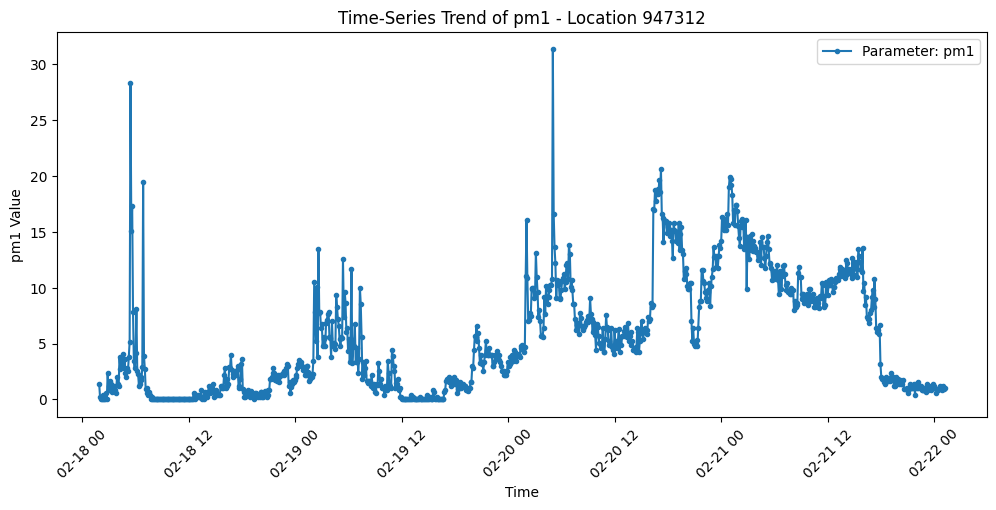

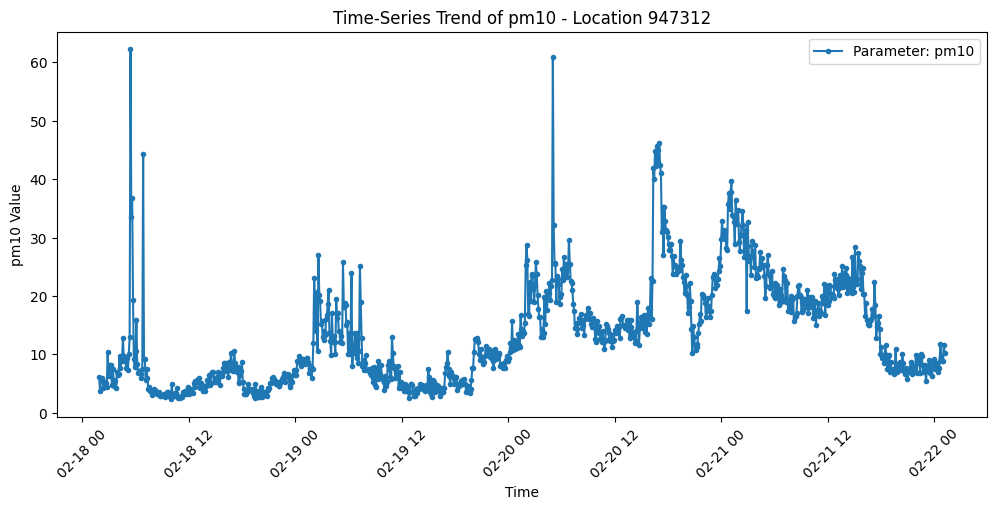

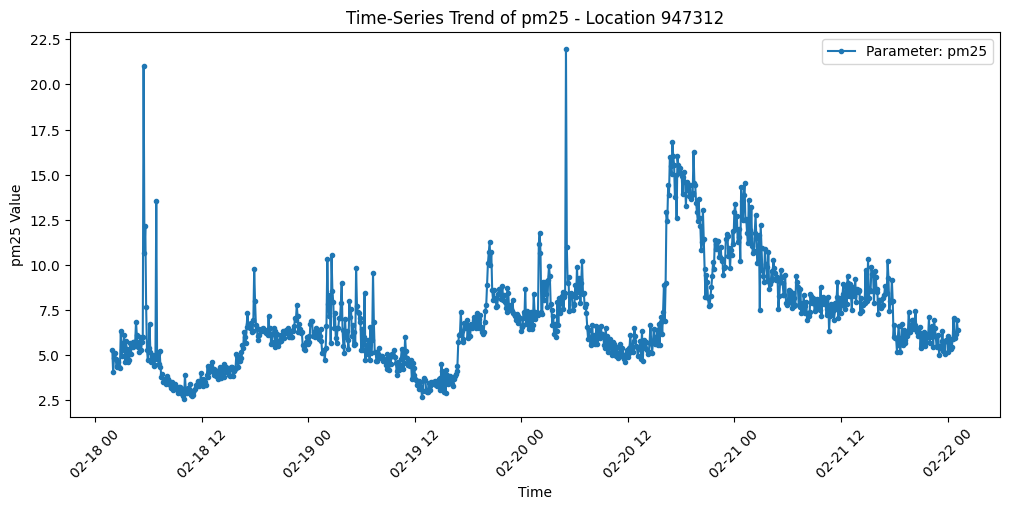

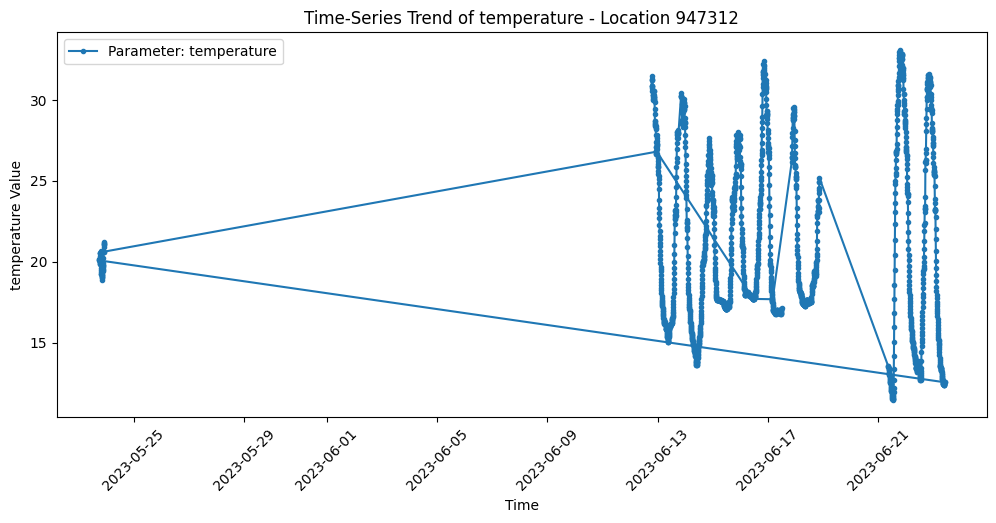

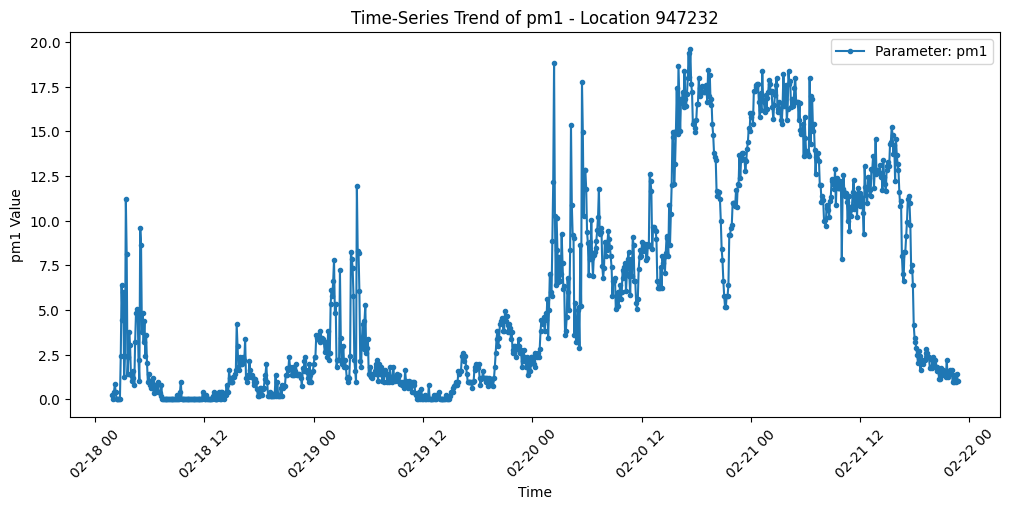

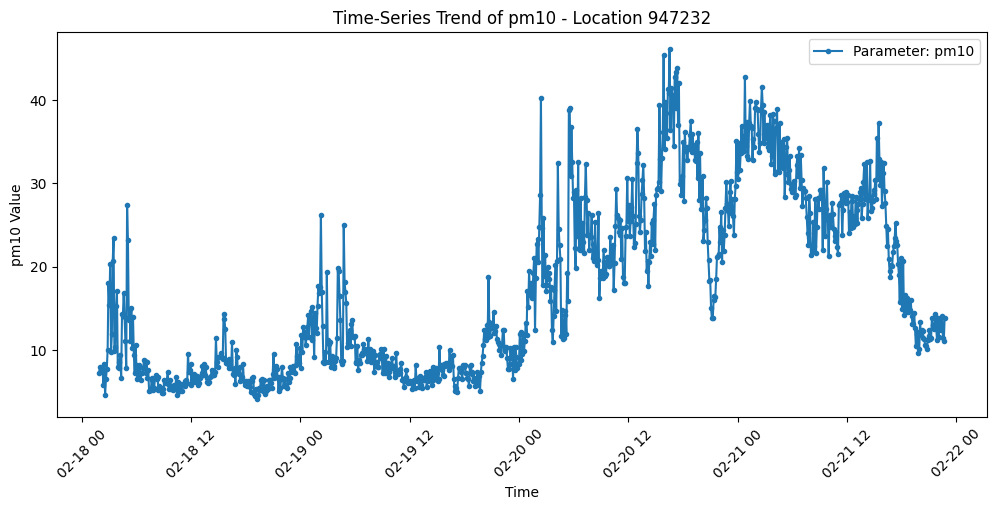

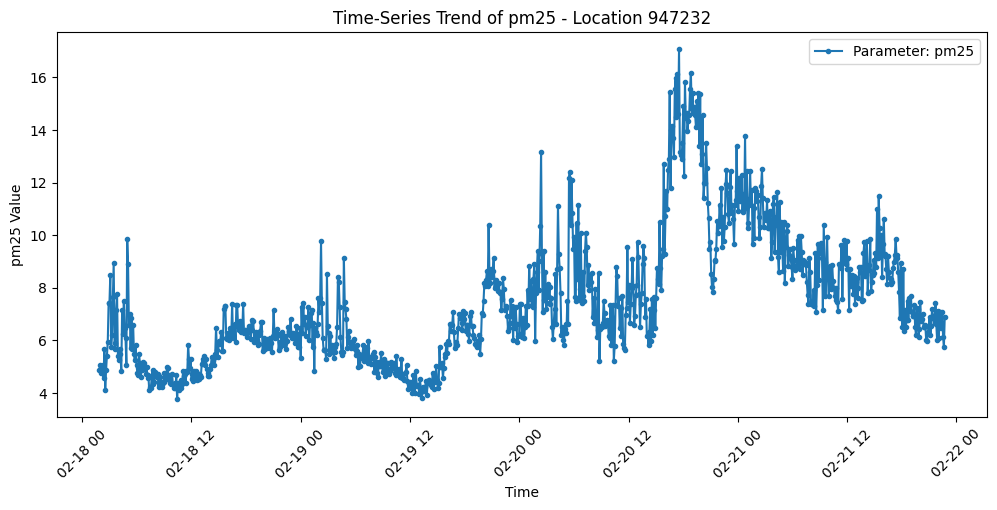

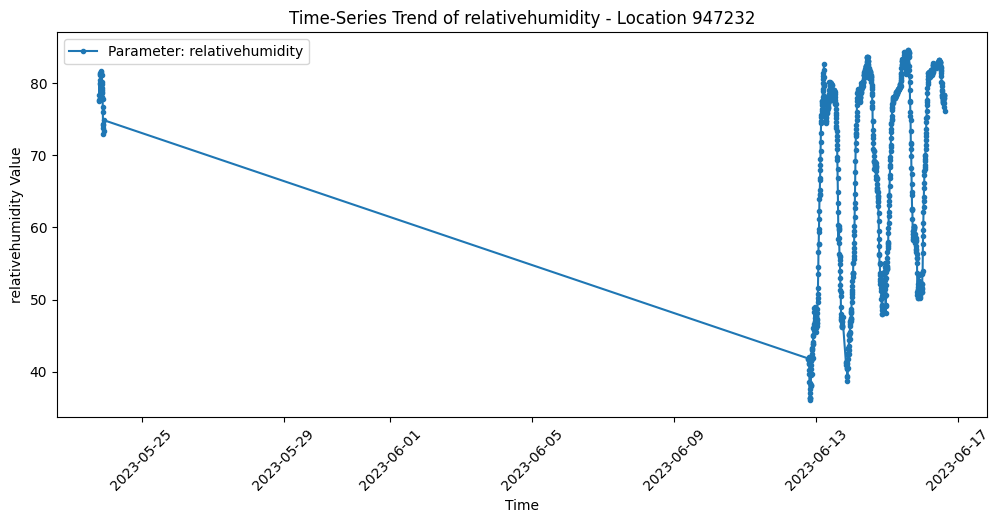

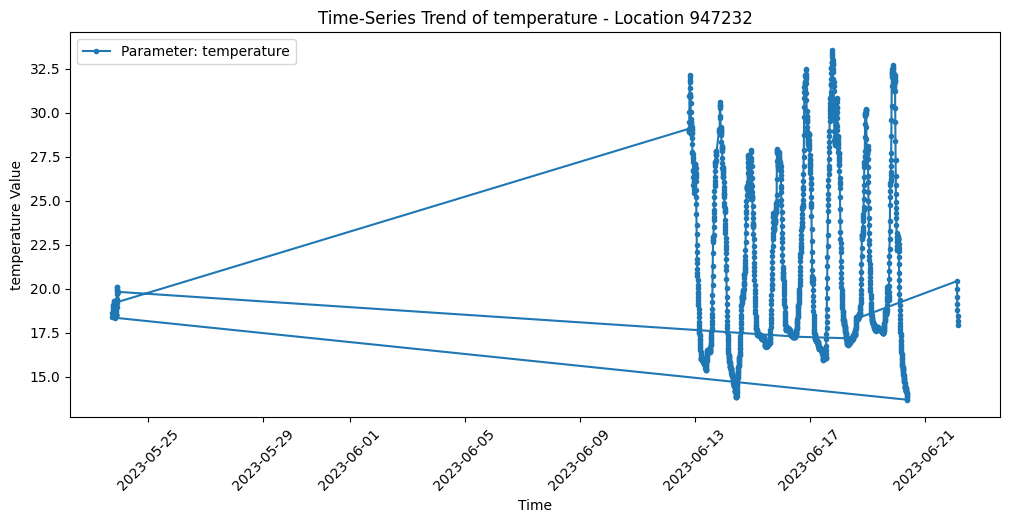

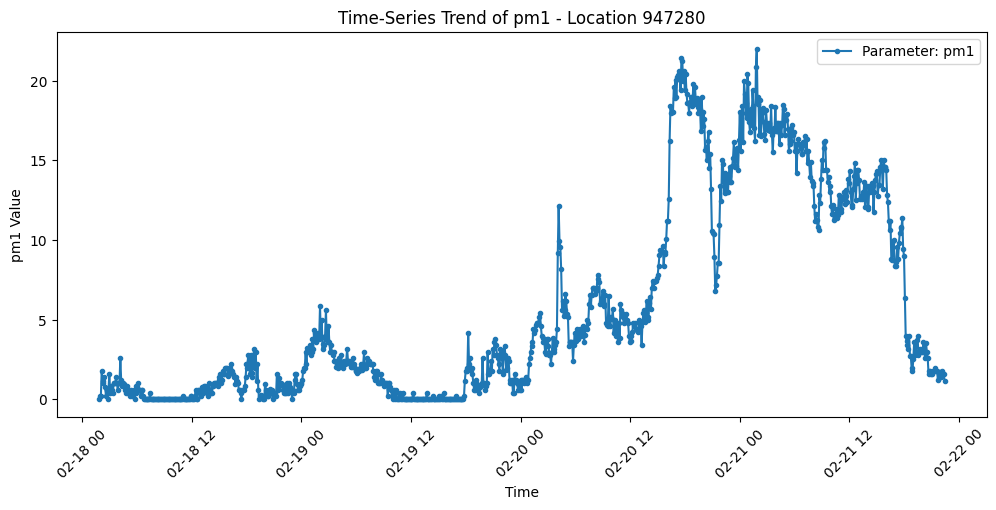

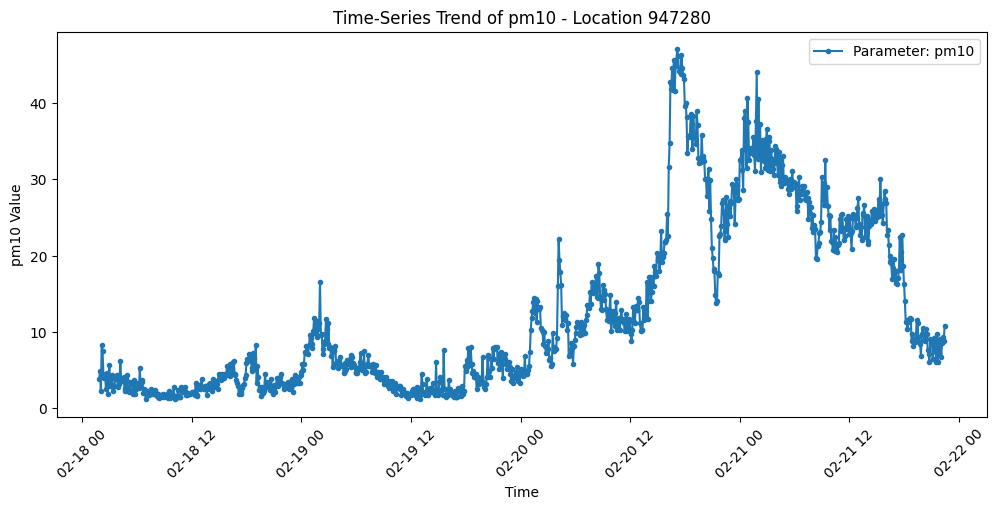

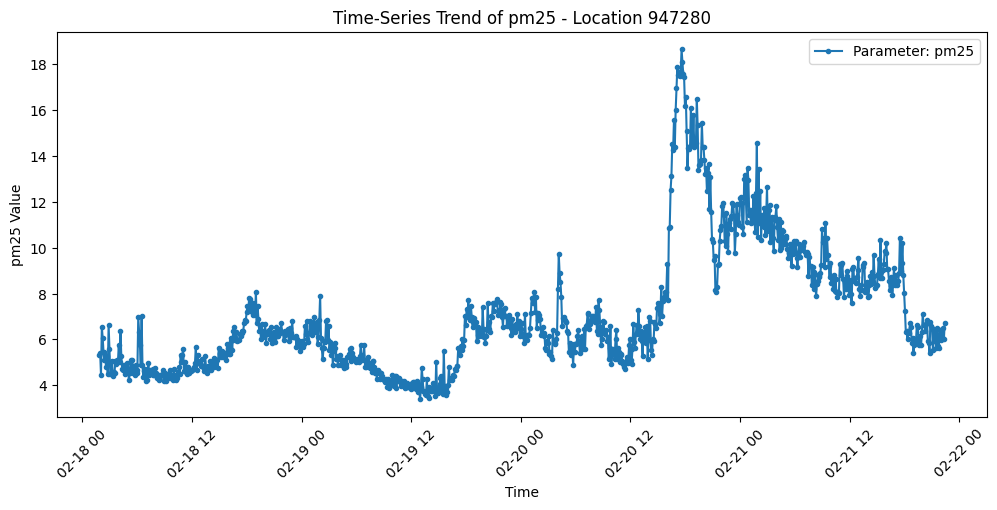

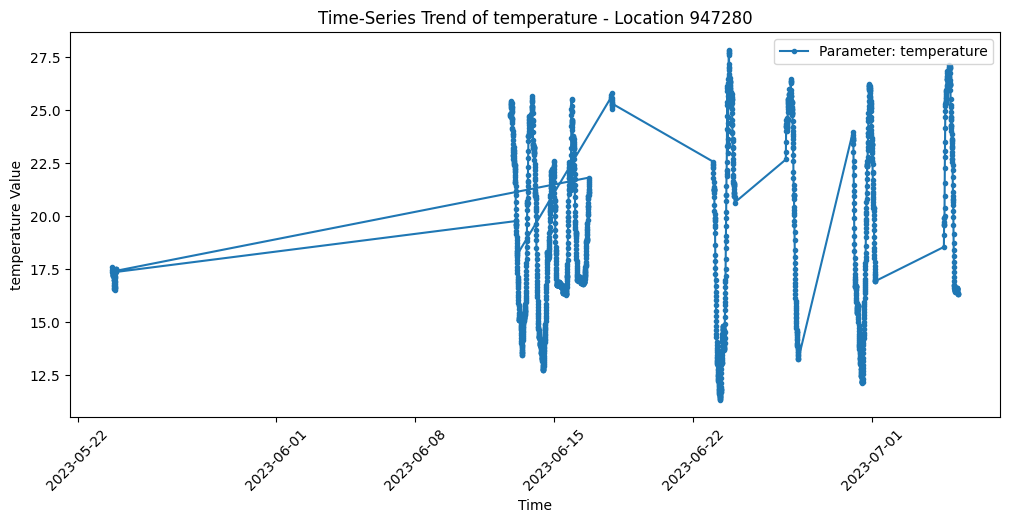

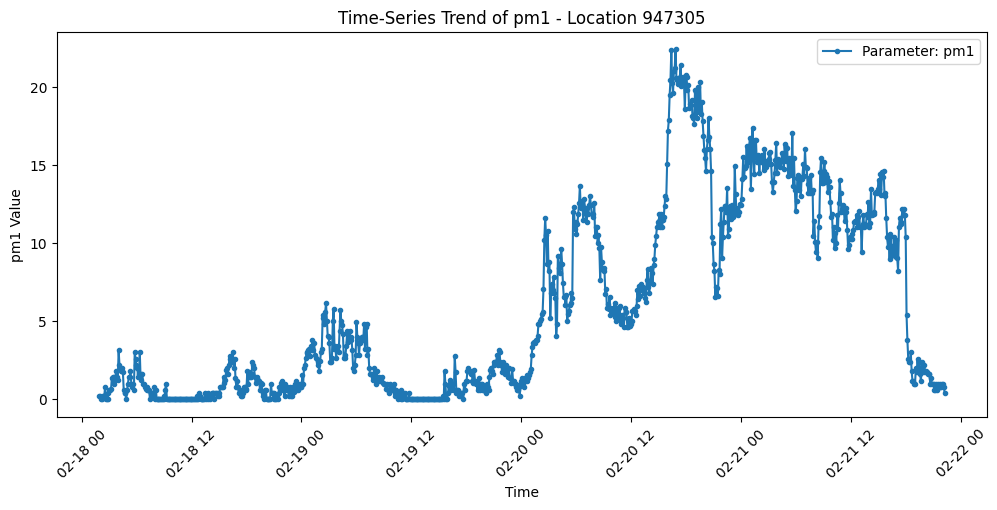

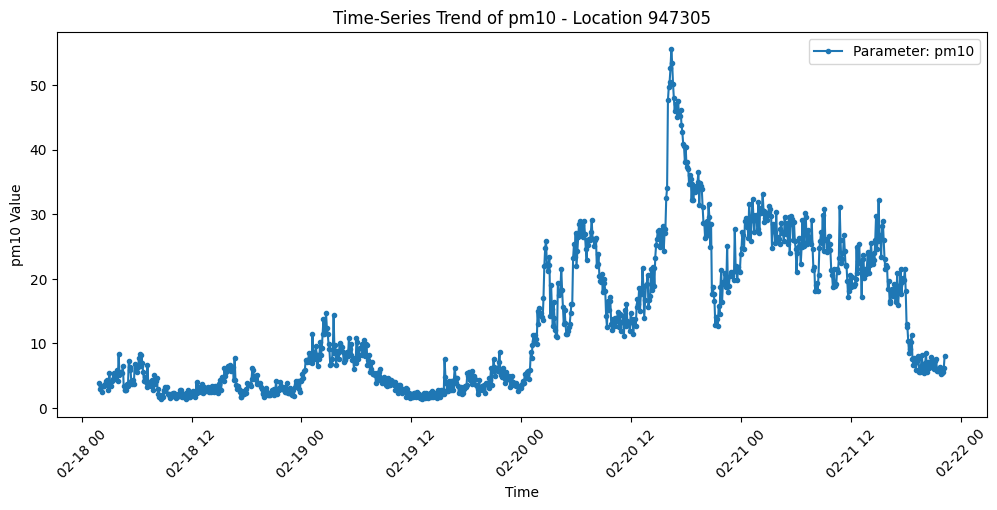

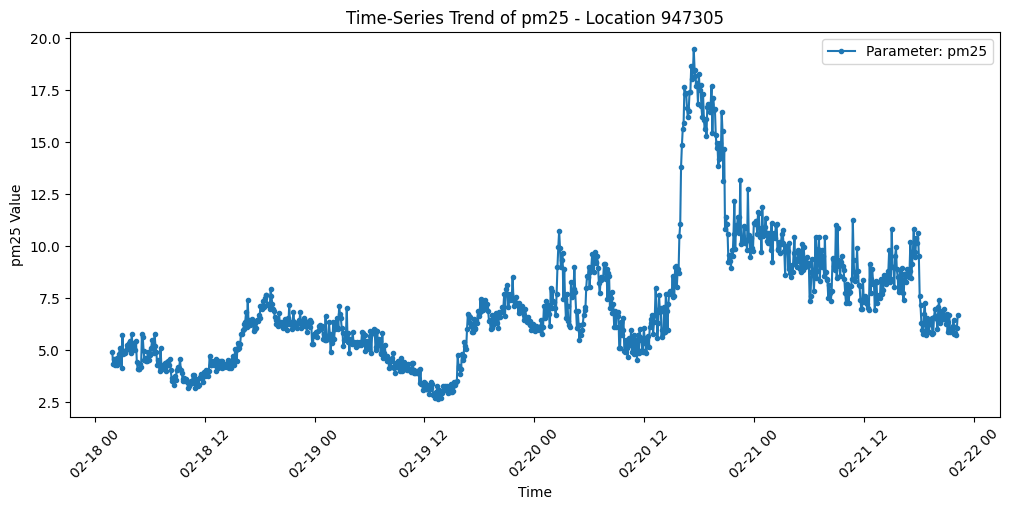

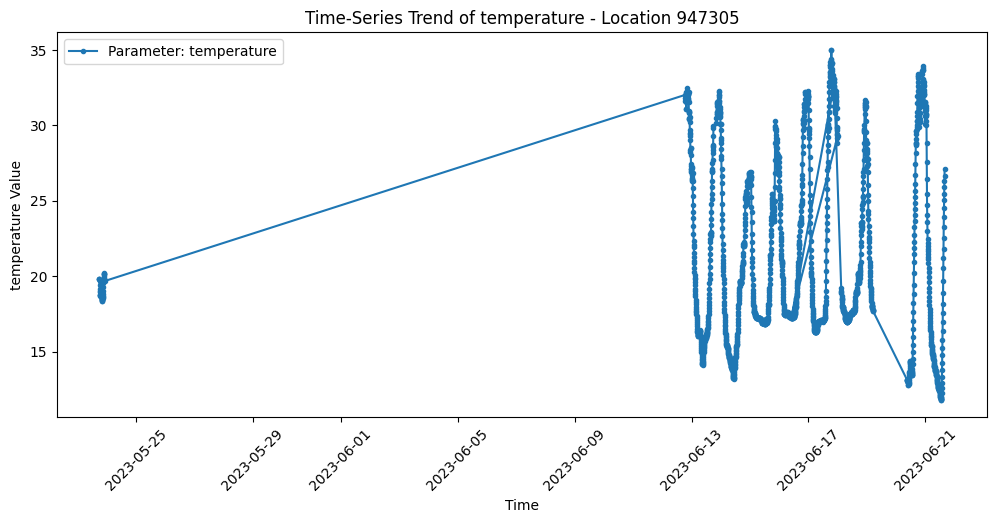

In [12]:
import matplotlib.pyplot as plt

# Loop through each unique location_id
for location in df['location_id'].unique():
    df_location = df[df['location_id'] == location]  # Filter data for this location
    
    # Loop through each unique parameter
    for parameter in df_location['parameter'].unique():
        df_param = df_location[df_location['parameter'] == parameter]  # Filter data for this parameter
        
        plt.figure(figsize=(12, 5))
        plt.plot(df_param['epoch'], df_param['value'], marker='o', linestyle='-', markersize=3, label=f"Parameter: {parameter}")
        plt.xlabel("Time")
        plt.ylabel(f"{parameter} Value")
        plt.title(f"Time-Series Trend of {parameter} - Location {location}")
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

In [13]:
location = client.locations.get(2795)

print(location)

LocationsResponse(headers=Headers(x_ratelimit_limit=60, x_ratelimit_remaining=59, x_ratelimit_used=1, x_ratelimit_reset=60), meta=Meta(name='openaq-api', website='/', page=1, limit=100, found=1), results=[Location(id=2795, name='Kufstein Praxmarerstraße', locality=None, timezone='Europe/Vienna', country=CountryBase(id=89, code='AT', name='Austria'), owner=OwnerBase(id=4, name='Unknown Governmental Organization'), provider=ProviderBase(id=171, name='EEA Austria'), is_mobile=False, is_monitor=True, instruments=[InstrumentBase(id=2, name='Government Monitor')], sensors=[SensorBase(id=5831, name='no2 µg/m³', parameter=ParameterBase(id=5, name='no2', units='µg/m³', display_name='NO₂ mass')), SensorBase(id=5832, name='pm10 µg/m³', parameter=ParameterBase(id=1, name='pm10', units='µg/m³', display_name='PM10'))], coordinates=Coordinates(latitude=47.586398191301086, longitude=12.173609404274107), bounds=[12.173609404274107, 47.586398191301086, 12.173609404274107, 47.586398191301086], distance=N

### Get names and location IDs for stations in the Palisades region

In [14]:
radius = 10000
limit = 25
latitude = 34.03213 
longitude = -118.51198

response = client.locations.list(coordinates=(latitude, longitude), radius=radius, limit=limit)

In [15]:
for location_curr in response.results:
    print(location_curr.name, location_curr.id)

West Los Angeles - V 1410
West Los Angeles - V 8904
5986 - Palms El 290586
Kenter Canyon ES (4699) 947182
Coeur D Alene ES (6342) 947207
Webster MS (8481) 947212
Grand View ES (4247) 947218
Pacific Palisades ES (5959) 947232
Westwood ES (7740) 947262
2741 - Community Magnet 947263
Walgrove ES (7603) 947278
Revere MS (8356) 947280
Brentwood Sci Mag ES (2507) 947305
7699 - Westminster El 947311
Canyon ES (2795) 947312
Brockton ES (2548) 947313
Marquez ES (5164) 947333
Warner ES (7616) 947336
Westminster El (7699) 1285716
Marco Triangle Park, Venice, California 1716811
Terasaki Life Sciences 2812558
UCLA Ronald Reagan Hospital 2812560
Sycamore Court Apartments 2812572
Sproul Hall 2812581
Anderson 2812720


Pretty print of JSON response to better understand the structure of the data.

In [16]:
from pprint import pprint

# Assuming `location` is the object
pprint(location)


LocationsResponse(headers=Headers(x_ratelimit_limit=60,
                                  x_ratelimit_remaining=59,
                                  x_ratelimit_used=1,
                                  x_ratelimit_reset=60),
                  meta=Meta(name='openaq-api',
                            website='/',
                            page=1,
                            limit=100,
                            found=1),
                  results=[Location(id=2795,
                                    name='Kufstein Praxmarerstraße',
                                    locality=None,
                                    timezone='Europe/Vienna',
                                    country=CountryBase(id=89,
                                                        code='AT',
                                                        name='Austria'),
                                    owner=OwnerBase(id=4,
                                                    name='Unknown Governmental '
   